# Milestone 3 - Media coverage of violent events in war zone

## 1. Hypothesis and Data retrieval

Modern media coverage of armed conflicts is at the center of many ethical discussions. The usual critisism is to say that newspapers focus their articles topics arbitrarily and often have a debatable sense of priority.

If such a claim were true, the consequences could be significant given the importance of modern medias in inhabitants of western countries daily lives. A lack of coverage of a conflict by newspapers could make people think that the situation in countries at war improved when it has not.

### **Our hypothesis is that there exists a loss of interest of medias over time for some countries even when this country is still at war and that this coverage is biased towards western countries' views and in particular the U.S.A.**

To achieve this we chose to use the [**GDELT 2.0 dataset**](https://www.gdeltproject.org/). 

We chose to analyse the media coverage of violent events in some specific countries (Afghanistan, Syria, Iraq, Pakistan and Mexico) over the years 2000 to 2016.

We used :

* *ActionGeo_CountryName*, the 2-character FIPS10-4 country code for the location of the events to get the countries.
* [*EventRootCode*](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf) 18, 19 and 20 that correspond to the most violent events in the documentation.
* *MonthYear* to have the date (in month and year) of each event
* *Events* that we got from our SQL query as being the number of events per month
* *Articles* from our SQL query as well, being the number of Articles per month

We also chose to extract data from the [**UCDP**](http://ucdp.uu.se/) dataset, we kept only our featured countries and the best estimation given for the number of deaths per year.

## 2. Imports and global names

In [26]:
import pandas as pd
import pyarrow.parquet as pq
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbs
import numpy as np

In [27]:
total_articles_file = 'totart_code181920.csv'
total_events_file = 'totevent_code181920.csv'
ucdp_file = 'ged171.csv'
gdelt_file = 'big_query_2000_2016.csv'
years = [2000, 2016]

## 3. Data preprocessing

## 3.1 Processing of the UCDP dataset

### 3.1.1 DataFrame creations

*articles_year* and *events_year* represent the number of articles (resp. events) per year in the world.

In [28]:
articles_year = read_csv(total_articles_file)
events_year = read_csv(total_events_file)

events_year.head()

,Year,NumEvents
21,2000,330047
22,2001,390659
23,2002,344684
24,2003,403647
25,2004,401826


*deaths* represent the number of deaths by country per year

In [29]:
deaths = read_csv(ucdp_file, year_col='year')
deaths = deaths[['year', 'country', 'best']]
deaths.columns = ['Date', 'Country', 'Deaths']

deaths.head()

,Date,Country,Deaths
0,2010,Yemen (North Yemen),2
1,2011,Yemen (North Yemen),0
2,2011,Yemen (North Yemen),0
3,2012,Yemen (North Yemen),5
4,2012,Yemen (North Yemen),5


### 3.1.2 Country separation

Here we create one dataframe per country

In [30]:
def deaths_country(_df, country_name):
    x = _df[_df['Country'] == country_name].drop('Country', axis=1).groupby('Date').sum().reset_index()
    if(country_name == 'Mexico'):
        # We need to artificially add some rows for mexico due to missing (no deaths) data these years
        x = x.append(pd.DataFrame([[2003, 0], [2000, 0], [2001, 0]], columns=['Date', 'Deaths'])).sort_values('Date')
    x['Deaths'] = x['Deaths']
    return x.set_index('Date')

In [31]:
deaths_irq = deaths_country(deaths, 'Iraq')
deaths_afg = deaths_country(deaths, 'Afghanistan')
deaths_mex = deaths_country(deaths, 'Mexico')
deaths_pak = deaths_country(deaths, 'Pakistan')

deaths_irq.head()

,Deaths
Date,
2000,185
2001,27
2002,111
2003,7999
2004,4365


## 3.2 Processing of our aggregation of the GDELT dataset

We first tried to get the data from the cluseter but the dataset present on it was a subset of GDELT. Therefore most of the features were missing. To get the location of an event we used at first "Source" and "Target" field that matched the country we were intrested in. But those entries were not consistent.
The full dataset was supposed to have an ActionGeo_Country code which represent the county were the event took place. We were also supposed to have access to features like "MonthYear", "EventRootCode",...

For all those reasons we decided to stop using the cluster and make our query on the full GDELT dataset using the [Google Big Query](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events)

The sql queries can be found on the repository

### 3.2.1 DataFrame creation

*df* represents our aggregated gdelt data(sub)set

In [32]:
df = pd.read_csv(gdelt_file)
df.columns = ['Country', 'Date', 'EventCode', 'Events', 'Articles']

### 3.2.2 Normalization

This part is important. To be able to correctly analyse our data, we need to normalize the number of articles (resp. events) per year in the aggregated gdelt dataset by the total number of articles (resp. events) in the world this year.

In [33]:
tmp = pd.DataFrame(df['Date'].apply(lambda x: int(x / 100))).rename(columns={'Date': 'Year'})
tmp[['Articles', 'Events']] = df[['Articles', 'Events']]
tmp = tmp.merge(articles_year).merge(events_year)
tmp['Articles'] = (tmp['Articles'] / tmp['NumArticles'])
tmp['Events'] = (tmp['Events'] / tmp['NumEvents'])

df[['Articles', 'Events']] = tmp[['Articles', 'Events']]

tmp.drop(['NumEvents', 'NumArticles', 'Year'], axis=1).head()

,Articles,Events
0,0.005237,0.004158
1,0.004822,0.003789
2,0.004538,0.004389
3,0.004398,0.003578
4,0.004289,0.003825


The data that we get out of our query is the number of Event and the number of Articles aggregated per country, MonthYear and EventCode.
Aggregating the data this way enables us to work on a consise dataset(compared to the original enormous GDELT). However we still keep the different event code and month data separated for further analysis.

In [34]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,0.004158,0.005237
1,SY,201608,19,0.003789,0.004822
2,SY,201602,19,0.004389,0.004538
3,SY,201510,19,0.003578,0.004398
4,SY,201612,19,0.003825,0.004289


## 3.3 Separation by country and aggregation per year and event code

In this part, we will create new dataframes that will hold our data aggregated by country and date, while forgetting (for now) the event types.

We will also create a new column, called *Ratio*, that will represent the ratio (in a given country and year) of the number of articles over the number of events (both normalized).

In [35]:
df_grouped = df.groupby(['Date', 'Country']).sum().drop(['EventCode'], axis=1).sort_index(level=[0,1])

df_merged = df_grouped.reset_index()

irq = df_country(df_merged, 'IZ')
mex = df_country(df_merged, 'MX')
pak = df_country(df_merged, 'PK')
afg = df_country(df_merged, 'AF')
syr = df_country(df_merged, 'SY')

df_merged.head()

,Date,Country,Events,Articles
0,200001,AF,0.002455,0.002453
1,200001,IZ,0.000407,0.000301
2,200001,MX,0.004393,0.005433
3,200001,PK,0.002239,0.002177
4,200001,SY,0.000305,0.000275


Creation of the ratio column.

In [36]:
df_year = df_merged.copy()

df_year['Date'] = df_year['Date'].apply(lambda d: int(d/100))

df_year = df_year.groupby(['Date', 'Country']).sum()
df_year = (df_year / df_year.std()).reset_index()

df_year['Ratio'] = df_year['Articles'] / df_year['Events'].astype('float')

irq_year1 = df_country(df_year, 'IZ')
mex_year1 = df_country(df_year, 'MX')
pak_year1 = df_country(df_year, 'PK')
afg_year1 = df_country(df_year, 'AF')
syr_year1 = df_country(df_year, 'SY')

df_year.head()

,Date,Country,Events,Articles,Ratio
0,2000,AF,4.242186,3.764931,0.887498
1,2000,IZ,3.159566,2.827667,0.894954
2,2000,MX,5.154469,4.508636,0.874704
3,2000,PK,4.749720,4.614945,0.971625
4,2000,SY,2.030646,1.616556,0.796080


Merging of both dataset informations.

In [37]:
irq_year = deaths_irq.join(irq_year1)
mex_year = deaths_mex.join(mex_year1)
pak_year = deaths_pak.join(pak_year1)
afg_year = deaths_afg.join(afg_year1)

irq_year.head()

,Deaths,Events,Articles,Ratio
Date,,,,
2000,185,3.159566,2.827667,0.894954
2001,27,2.716475,2.373155,0.873615
2002,111,2.519822,2.051480,0.814137
2003,7999,3.116896,2.731123,0.876232
2004,4365,3.156413,2.964102,0.939073


## 3.4 Some plots and describes

In [38]:
irq_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,4459.294118,3.510611,3.290647,0.931359
std,4390.300499,0.759707,0.838999,0.065194
min,27.000000,2.519822,2.051480,0.814137
25%,1407.000000,2.992851,2.731123,0.887269
50%,3521.000000,3.159566,2.964102,0.934624
75%,4609.000000,4.152762,3.983813,0.965524
max,15010.000000,5.115785,4.944996,1.068138


In [39]:
mex_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,1115.764706,3.293395,3.102410,0.929565
std,1041.491450,1.255188,1.299699,0.088687
min,0.000000,1.543282,1.156241,0.693171
25%,187.000000,2.561258,2.286448,0.874704
50%,776.000000,2.906426,2.898550,0.943558
75%,1699.000000,3.873716,3.821229,0.990383
max,3313.000000,6.125149,6.263692,1.046640


In [40]:
pak_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,2290.882353,3.133597,2.920294,0.935425
std,2437.833974,0.931921,0.858562,0.060050
min,1.000000,1.900609,1.850691,0.855652
25%,241.000000,2.588347,2.239257,0.892569
50%,1366.000000,2.827711,2.513238,0.930562
75%,3540.000000,3.894146,3.522774,0.960478
max,7460.000000,4.749720,4.614945,1.089553


In [41]:
afg_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,7038.176471,2.971707,2.661773,0.895807
std,5235.884622,0.855483,0.802716,0.071448
min,817.000000,1.963615,1.514238,0.771148
25%,4982.000000,2.431927,2.166448,0.855352
50%,6499.000000,2.793658,2.471398,0.887498
75%,7822.000000,3.324882,2.993471,0.937075
max,18707.000000,4.875105,4.743734,1.050429


## 4. Analysis

## 4.1 Analysis by country per year

# TODO : change plots and discuss them

## Iraq

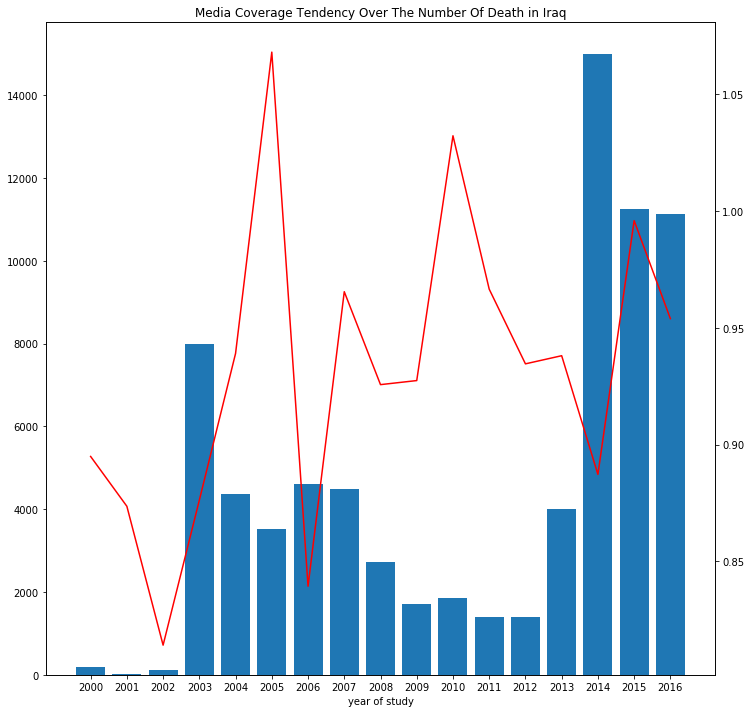

In [42]:
plot_tendency('Iraq', irq_year['Deaths'], irq_year['Ratio'])

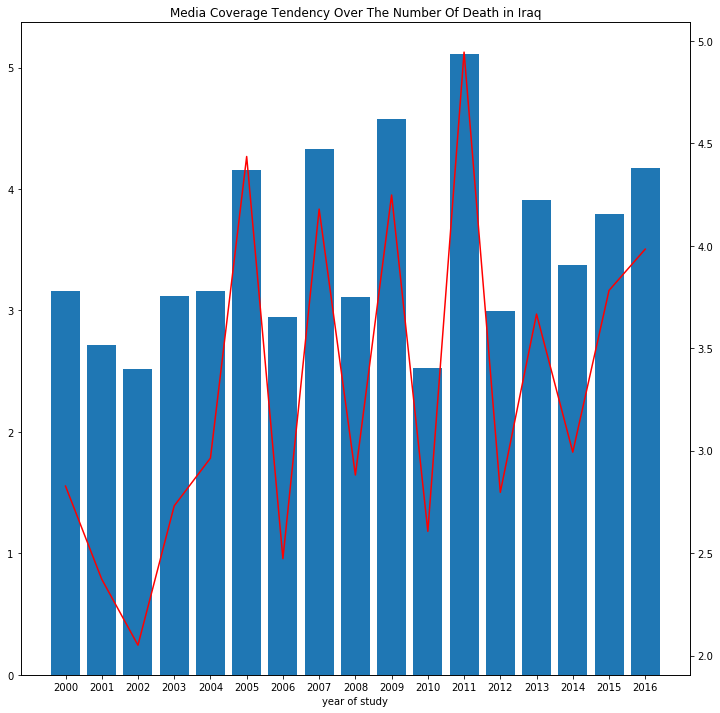

In [43]:
plot_tendency('Iraq', irq_year['Events'], irq_year['Articles'])

## Afghanistan

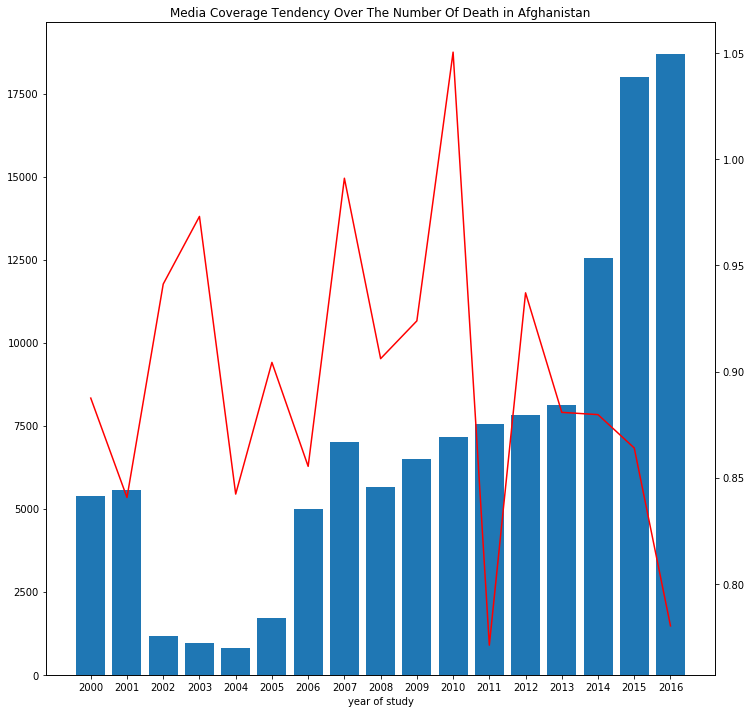

In [44]:
plot_tendency('Afghanistan', afg_year['Deaths'], afg_year['Ratio'])

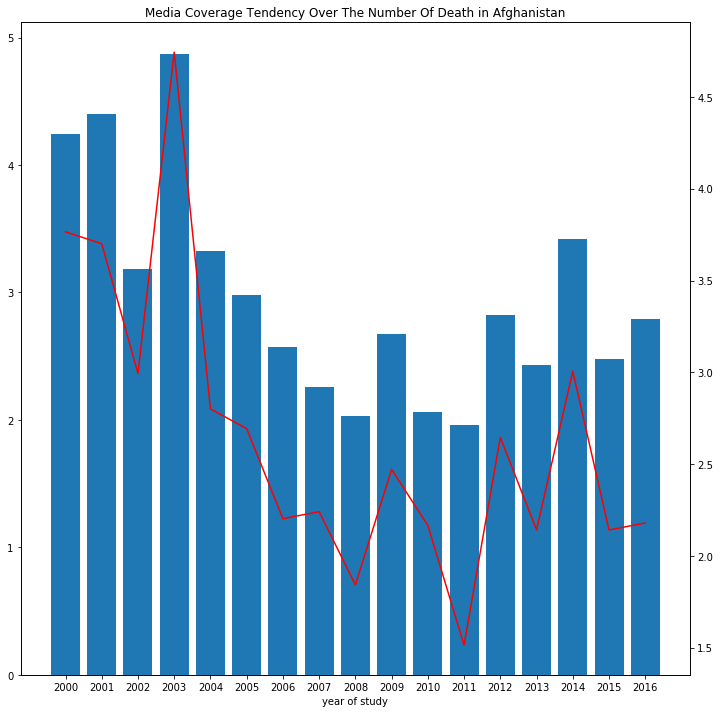

In [45]:
plot_tendency('Afghanistan', afg_year['Events'], afg_year['Articles'])

## Pakistan

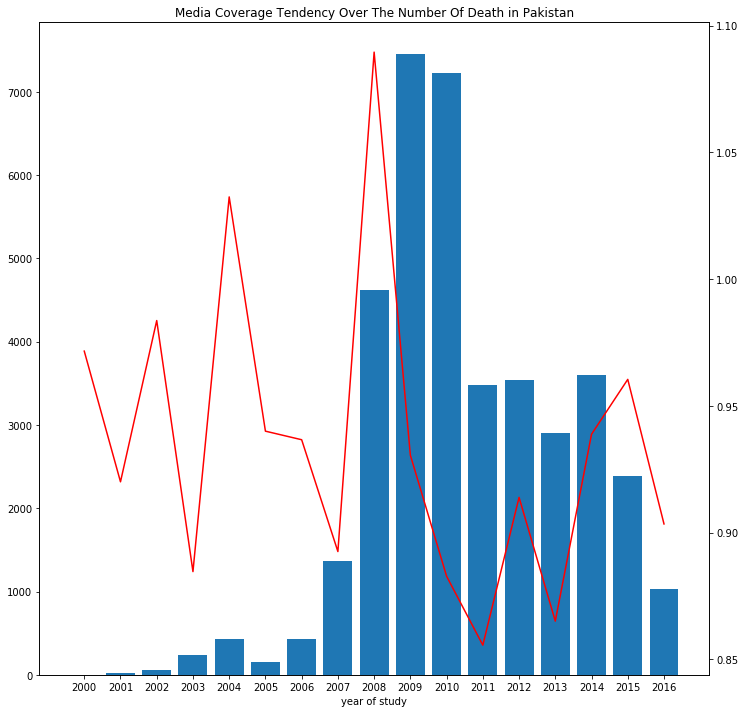

In [46]:
plot_tendency('Pakistan', pak_year['Deaths'], pak_year['Ratio'])

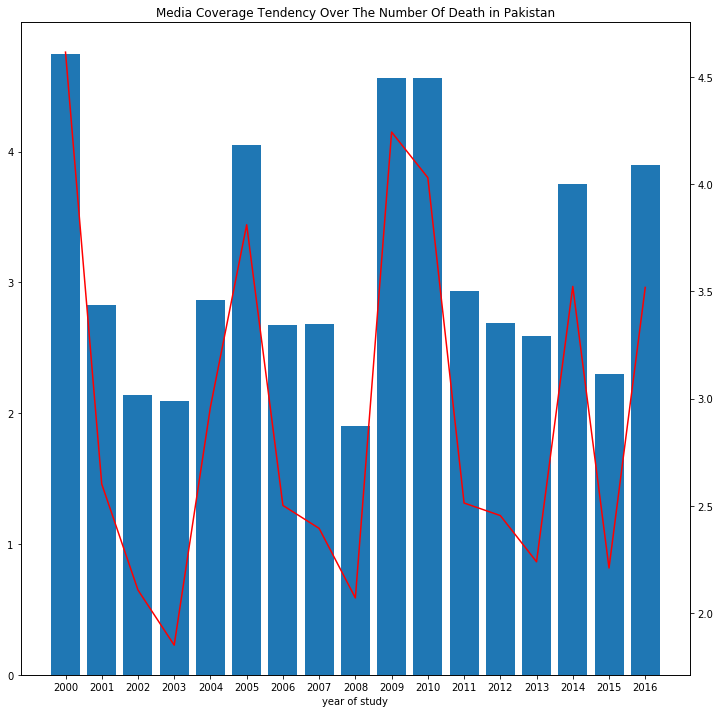

In [47]:
plot_tendency('Pakistan', pak_year['Events'], pak_year['Articles'])

## Mexico

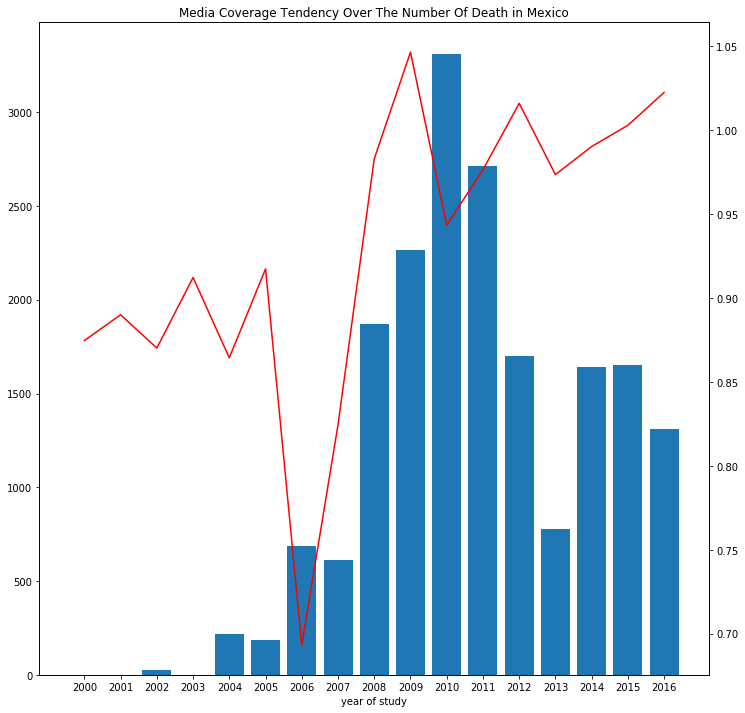

In [48]:
plot_tendency('Mexico', mex_year['Deaths'], mex_year['Ratio'])

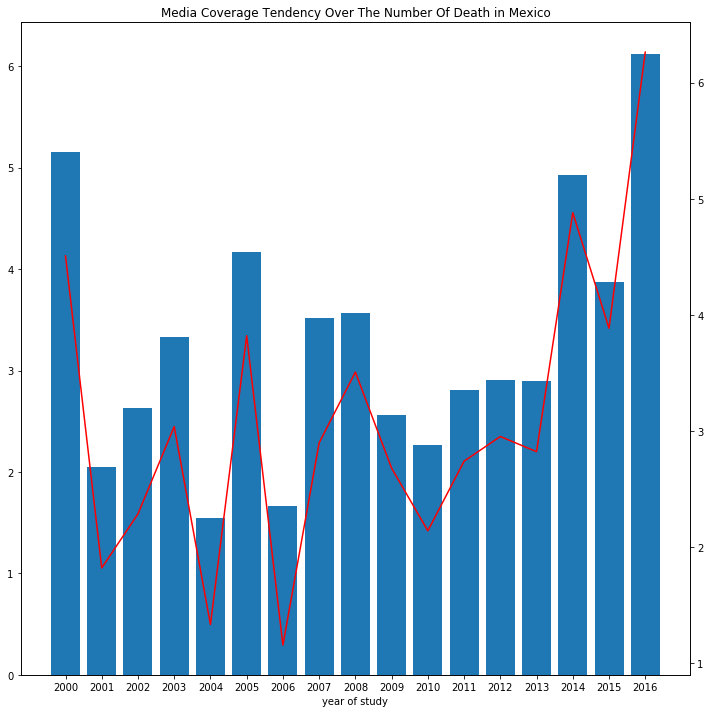

In [49]:
plot_tendency('Mexico', mex_year['Events'], mex_year['Articles'])

## Syria

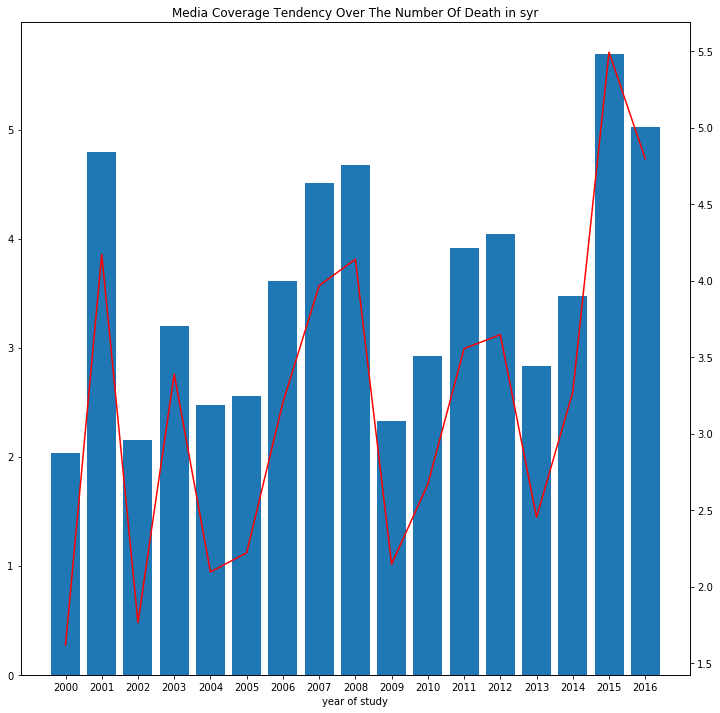

In [50]:
plot_tendency('syr', syr_year1['Events'], syr_year1['Articles'])

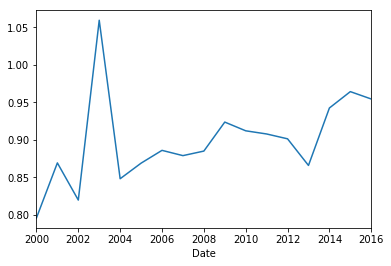

In [51]:
syr_year1['Ratio'].plot()

## 4.2 Analysis by Country per Event Code

In [52]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,0.004158,0.005237
1,SY,201608,19,0.003789,0.004822
2,SY,201602,19,0.004389,0.004538
3,SY,201510,19,0.003578,0.004398
4,SY,201612,19,0.003825,0.004289


In [53]:
def df_env_year(_df, country_code):
    x = _df[_df['Country'] == country_code].drop('Country', axis=1)
    x['Date'] = x['Date'].apply(lambda d: int(d / 100))
    return x.groupby(['Date', 'EventCode']).mean()

df_env = df.copy()

df_env['Ratio'] = df_env['Articles'] / df_env['Events'].astype('float')

df_env.drop(['Articles', 'Events'], axis=1, inplace=True)

irq_ev = df_env_year(df_env, 'IZ')
mex_ev = df_env_year(df_env, 'MX')
afg_ev = df_env_year(df_env, 'AF')
pak_ev = df_env_year(df_env, 'PK')
syr_ev = df_env_year(df_env, 'SY')

## Iraq

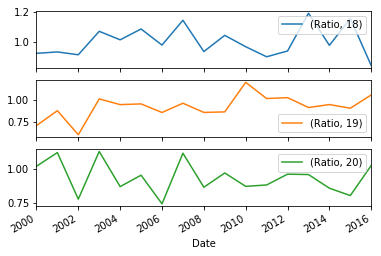

In [54]:
irq_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Afghanistan

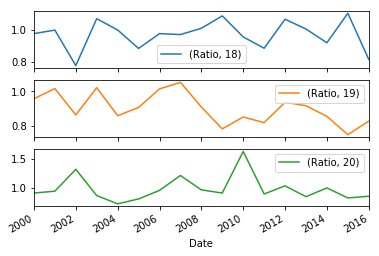

In [55]:
afg_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Pakistan

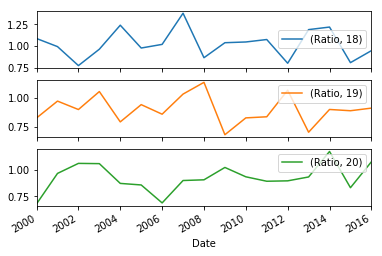

In [56]:
pak_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Mexico

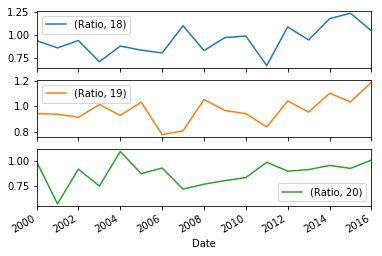

In [57]:
mex_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Syria

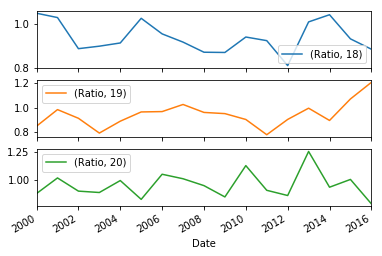

In [58]:
syr_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

As we can see, the type of the events (18, 19 or 20) seems not to influence too much the final ratio between the number of events (i.e. each event has a relatively similar curve shape). This means that our choice of events is sound and can be used without worrying too much about event importance.

## 4.3 Bias of article source

In [59]:
te = pd.read_csv("top_event_2000_2016.csv")
ta = pd.read_csv("top_acticles_2000_2016.csv")
te.set_index("ActionGeo_CountryCode").head(10)

,Sum_Events
ActionGeo_CountryCode,
US,9495320
IS,1388619
PK,1388042
IZ,1244830
AF,1176532
SY,1153458
UK,1054506
IN,1012818
RS,777605


In [60]:
ta.set_index("ActionGeo_CountryCode").head(10)

,Sum_Articles
ActionGeo_CountryCode,
US,126189062
SY,18233243
IS,16038607
IZ,15565613
AF,14920597
PK,14025192
UK,9708506
IN,8898081
AS,8213297


## 5. Results

## 6. Useful functions

In [61]:
def read_csv(filename, years=years, year_col='Year'):
    x = pd.read_csv(filename)
    x = x[(x[year_col] >= years[0]) & (x[year_col] <= years[1])]
    return x

In [62]:
def df_country(_df, country):
    return _df[_df.Country == country].drop('Country', axis=1).set_index(['Date'])

In [63]:
# Plot a barplot of the number od death per year, over the ratio number of article per event per year.
def plot_tendency(country_name,deaths, ratio):
    #global parameters
    fig_height = 12
    fig_weight = 12
    date = np.arange(2000,2017,1,dtype=np.int64) # stop value excluded
    year_xlabel = r"year of study"
    left_axis = r"ratio article/event"
    right_axis = r"number of deaths"    
    
    tendency_title = r"Media Coverage Tendency Over The Number Of Death in "+country_name
    f,ax_ = plt.subplots(sharex=True)
    f.set_figheight(fig_height)
    f.set_figwidth(fig_weight)
    plt.title(tendency_title)
    plt.xlabel(year_xlabel)
    
    ax_.set_xticks(date)
    ax_right = ax_.twinx()

    ax_.bar(date,deaths)
    ax_right.plot(date,ratio,color='r' )

    plt.show()